<a href="https://colab.research.google.com/github/Chia-Yin-Lee/NTHU/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title show your CPU or GPU details
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3709858742663289867
 xla_global_id: -1]

In [ ]:
#@title connect google drive folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/thesis

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1raSKmAWv2_XXKGBzNrK2IyJ_jALmDf6Q/thesis


In [ ]:
#@title Import packages

import math
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pandas as pd
import numpy as np
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

## Tasks to be done:
- compare PCA, SVD, SAE, PCA1, SVD1, SAE1
- compare no-text and text-included data
- diff reit focus on diff column from 'TheBusinessTimes_reindex.csv'

## Combine financial info and text info into 1 dataframe

In [ ]:
df = pd.read_csv("TheBusinessTimes_reindex.csv", index_col=False)
df.head()

,Date,Headline,Contents,AW9U,C2PU,HMN,J85,Q5T,ACV,BMGU,...,O5RU,A17U,DHLU,BWCU,J91U,BUOU,AJBU,ME8U,M44U,M1GU
0,2022-04-11,Data centre S-Reits committed to sustainable g...,THE data centre industry has experienced treme...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-04-12,Data centre S-Reits committed to sustainable g...,THE data centre industry has experienced treme...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-04-13,Data centre S-Reits committed to sustainable g...,THE data centre industry has experienced treme...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-04-14,"I'm not the kingmaker,' says Sabana Reit direc...",SABANA Industrial Real Estate Investment Trust...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-04-15,"I'm not the kingmaker,' says Sabana Reit direc...",SABANA Industrial Real Estate Investment Trust...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
token_model = 'PCA_0'
#token_model = 'PCA_1'
#token_model = 'SVD_0'
#token_model = 'SVD_1'
#token_model = 'SAE_0'
#token_model = 'SAE_1'
df_token = pd.read_csv(f"TheBusinessTimes_{token_model}.csv", index_col=False)
df_token.head()

,PCA_Headline_vec_1,PCA_Headline_vec_2,PCA_Headline_vec_3,PCA_Headline_vec_4,PCA_Headline_vec_5,PCA_Contents_vec_1,PCA_Contents_vec_2,PCA_Contents_vec_3,PCA_Contents_vec_4,PCA_Contents_vec_5,...,PCA_Contents_vec_11,PCA_Contents_vec_12,PCA_Contents_vec_13,PCA_Contents_vec_14,PCA_Contents_vec_15,PCA_Contents_vec_16,PCA_Contents_vec_17,PCA_Contents_vec_18,PCA_Contents_vec_19,PCA_Contents_vec_20
0,-0.061236,-0.243265,0.532380,-0.380131,-0.265597,3.158073,1.373992,-2.056452,-0.765094,-1.208619,...,1.822804,0.152542,-0.782913,1.101026,-0.456379,2.000357,-0.346002,2.407549,0.914356,-0.500573
1,0.029765,-0.220844,0.540696,-0.350234,-0.156796,3.152936,1.407678,-2.166829,-0.721862,-1.048772,...,1.904778,0.337723,-0.738200,0.714493,-0.443113,2.325334,-0.327046,2.594676,1.057236,-0.568052
2,0.008107,-0.288790,0.570564,-0.409214,-0.105329,3.250472,1.373323,-2.007127,-0.853187,-1.125699,...,1.879361,0.112058,-0.913655,0.848632,-0.452553,2.085869,-0.438644,2.539559,1.154364,-0.817642
3,-0.272483,-0.325906,0.230411,-0.283777,0.064866,-1.405509,0.674284,-1.858105,0.789809,-1.337100,...,0.699361,1.923845,0.922017,0.940581,-1.383118,-0.053165,1.189250,1.125913,0.410619,-0.027414
4,-0.225731,-0.354574,0.206364,-0.285613,0.093329,-1.248899,0.766479,-1.738075,0.614599,-1.689411,...,0.622212,1.988305,0.370055,1.001185,-1.267837,-0.084718,1.226298,0.985684,0.614373,-0.144489


In [ ]:
df.head()

,Date,Headline,Contents,AW9U,C2PU,HMN,J85,Q5T,ACV,BMGU,...,O5RU,A17U,DHLU,BWCU,J91U,BUOU,AJBU,ME8U,M44U,M1GU
0,2022-04-11,Data centre S-Reits committed to sustainable g...,THE data centre industry has experienced treme...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-04-12,Data centre S-Reits committed to sustainable g...,THE data centre industry has experienced treme...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-04-13,Data centre S-Reits committed to sustainable g...,THE data centre industry has experienced treme...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-04-14,"I'm not the kingmaker,' says Sabana Reit direc...",SABANA Industrial Real Estate Investment Trust...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-04-15,"I'm not the kingmaker,' says Sabana Reit direc...",SABANA Industrial Real Estate Investment Trust...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#@title data_combination function

def data_combination(reit_name, df_text_original, df_token_original):
  file_name = f'{reit_name}.SI_df.csv'
  df_fin = pd.read_csv(file_name)
  df_text = copy.deepcopy(df_text_original)
  df_token = copy.deepcopy(df_token_original)

  try:
    df_token.insert(0, 'Date', df_text['Date'])
    df_token.insert(1, reit_name, df_text[reit_name])
  except:
    pass

  df_combined = df_fin.merge(df_token, on='Date', how='left')
  df_combined = df_combined.rename(columns={reit_name: 'REIT'})

  col_list = ['Date', 'Close', 'Open'] + list(df_combined.columns)[4:]
  return df_combined, col_list

# testing the function
reit = 'ACV'
df_ = data_combination(reit, df, df_token)
df_[0].head()

,Date,Symbol,Open,Close,Low,High,Volume,VolumeChangeAmount,VolumeChangeRate,MACD,...,PCA_Contents_vec1_11,PCA_Contents_vec1_12,PCA_Contents_vec1_13,PCA_Contents_vec1_14,PCA_Contents_vec1_15,PCA_Contents_vec1_16,PCA_Contents_vec1_17,PCA_Contents_vec1_18,PCA_Contents_vec1_19,PCA_Contents_vec1_20
0,2022-04-26,ACV.SI,0.580137,0.584854,0.575420,0.584854,789700,-1492400.0,-65.395907,0.033573,...,1.456299,-2.563756,4.551058,4.584189,-0.208850,-3.551799,-4.641689,-0.628772,-2.285663,-1.073052
1,2022-04-27,ACV.SI,0.584853,0.617869,0.580137,0.622586,7520900,6731200.0,852.374319,0.034722,...,1.408072,0.168366,1.536879,1.553556,-1.776096,-3.479581,0.892266,0.121843,-1.913378,-2.089730
2,2022-04-28,ACV.SI,0.613153,0.617869,0.608436,0.617869,2877900,-4643000.0,-61.734633,0.035226,...,1.776646,-0.097811,0.973406,1.645145,-1.436010,-3.239231,0.621213,0.221196,-2.406583,-2.261366
3,2022-04-29,ACV.SI,0.617869,0.608436,0.608436,0.617869,2440500,-437400.0,-15.198582,0.034467,...,-0.962464,-0.221737,0.123953,-1.510665,-2.399166,0.066279,-8.400807,3.188931,-4.423966,6.006779
4,2022-05-04,ACV.SI,0.608436,0.608436,0.603720,0.617869,4226300,1785800.0,73.173530,0.033480,...,1.607953,-0.659477,-1.385324,2.834042,2.251981,0.349856,-0.815895,-0.556842,-2.407646,2.002454


In [ ]:
#@title Load multiple data function

def load_data(reits, df_text, df_token):
  datasets = []

  for reit in reits:
      df, col_list = data_combination(reit, df_text, df_token)
      df = df[col_list]
      df.set_index('Date', drop=True, inplace=True)

      df_name = f'{reit}_df'

      # We add a prediction column and set dummy values to prepare the data for scaling
      df_ext = df.copy()
      df_ext['Prediction'] = df_ext['Close']
      datasets.append((df_name, df_ext))

  return datasets

#reits = ['JYEU', 'K71U', 'N2IU', 'OXMU', 'T82U', 'TS0U', 'UD1U']
reits = ['AU8U', 'BMGU', 'C38U', 'CEDU', 'CRPU', 'D5IU', 'J69U', 'P40U', 'SK6U']
#reits = ['A17U', 'AJBU', 'BUOU', 'BWCU', 'DHLU', 'J91U', 'M1GU', 'M44U', 'ME8U', 'O5RU']
datasets = load_data(reits, df, df_token)

In [ ]:
datasets


## LSTM

In [ ]:
#@title partition_dataset function
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [ ]:
#@title Training function
def Train(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 16):
  # Configure the neural network model
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])

  # An LSTM layer, which takes our mini-batches as input and returns the whole sequence
  model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
  # Another LSTM layer that takes the sequence from the previous layer but only returns five values
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mse')

  # Training the model
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test)
                    )

                      #callbacks=[early_stop])

  return model, history

In [ ]:
#@title Prediction function

def Predict(model, scaler_pred, x_test, y_test):
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)

  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  # Root Mean Square Error (RMSE)
  RMSE = np.sqrt(np.mean(np.square(np.subtract(y_test_unscaled, y_pred))))
  print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 2)} %')

  # R-squared (R^2)
  R2 = 1 - (np.sum(np.square(np.subtract(y_test_unscaled, y_pred))) / np.sum(np.square(np.subtract(np.mean(y_test_unscaled), y_test_unscaled))))
  print(f'R-squared (R^2): {np.round(R2, 2)} %')

  return y_pred, y_test_unscaled, MAE, MAPE, MDAPE, RMSE, R2

In [ ]:
#@title Scaling the Multivariate Input Data function

# The date from which on the date is displayed
start_date = "2022-04-26"
end_date = "2023-08-31"

MAE_dict = defaultdict(int)
MAPE_dict = defaultdict(int)
MDAPE_dict = defaultdict(int)
RMSE_dict = defaultdict(int)
R2_dict = defaultdict(int)

def a():
    return []
datasets_zoom = defaultdict(a)

nrows = datasets[0][1].shape[0]  # All the df.shape() should be the same!!

for dataset_name, df in datasets:

  # Convert the data to numpy values
  np_data_unscaled = np.array(df)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  print('The size of', dataset_name, 'is', np_data.shape)

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)

  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(df['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  # Set the sequence length - this is the timeframe used to make a single prediction
  sequence_length = 7

  # Prediction Index
  index_Close = df.columns.get_loc("Close")

  # Split the training data into train and train data sets
  # As a first step, we get the number of rows to train the model on 80% of the data
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

  # Create the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  test_data = np_data_scaled[train_data_len - sequence_length:, :]

  # Generate training data and test data
  x_train, y_train = partition_dataset(sequence_length, train_data)
  x_test, y_test = partition_dataset(sequence_length, test_data)

  # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
  print(x_train.shape, y_train.shape)
  print(x_test.shape, y_test.shape)

  # Validate that the prediction value and the input match up
  # The last close price of the second input sample should equal the first prediction value
  print(x_train[1][sequence_length-1][index_Close])
  print(y_train[0])

  # Train!
  model, history = Train(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 16)

  # Predict!
  y_pred, y_test_unscaled, MAE, MAPE, MDAPE, RMSE, R2 = Predict(model, scaler_pred, x_test, y_test)

  MAE_dict[dataset_name] = MAE
  MAPE_dict[dataset_name] = MAPE
  MDAPE_dict[dataset_name] = MDAPE
  RMSE_dict[dataset_name] = RMSE
  R2_dict[dataset_name] = R2

  # Add the difference between the valid and predicted prices
  train = pd.DataFrame(df['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
  valid = pd.DataFrame(df['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
  valid.insert(1, "y_pred", y_pred, True)
  valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)

  df_union = pd.concat([train, valid])

  # Zoom in to a closer timeframe
  df_union_zoom = df_union[df_union.index > start_date]
  datasets_zoom[dataset_name] = df_union_zoom

The size of AU8U_df is (337, 54)
(263, 7, 54) (263,)
(67, 7, 54) (67,)
0.4668407104419807
0.4668407104419807
378 7 54
Epoch 1/50
17/17 [==============================] - 5s 91ms/step - loss: 0.0358 - val_loss: 0.0112
Epoch 2/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0060 - val_loss: 0.0080
Epoch 3/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0046 - val_loss: 0.0123
Epoch 4/50
17/17 [==============================] - 1s 42ms/step - loss: 0.0040 - val_loss: 0.0092
Epoch 5/50
17/17 [==============================] - 1s 46ms/step - loss: 0.0044 - val_loss: 0.0229
Epoch 6/50
17/17 [==============================] - 1s 47ms/step - loss: 0.0042 - val_loss: 0.0139
Epoch 7/50
17/17 [==============================] - 1s 43ms/step - loss: 0.0034 - val_loss: 0.0310
Epoch 8/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0034 - val_loss: 0.0152
Epoch 9/50
17/17 [==============================] - 1s 38ms/step - loss: 0.0026 - val_loss

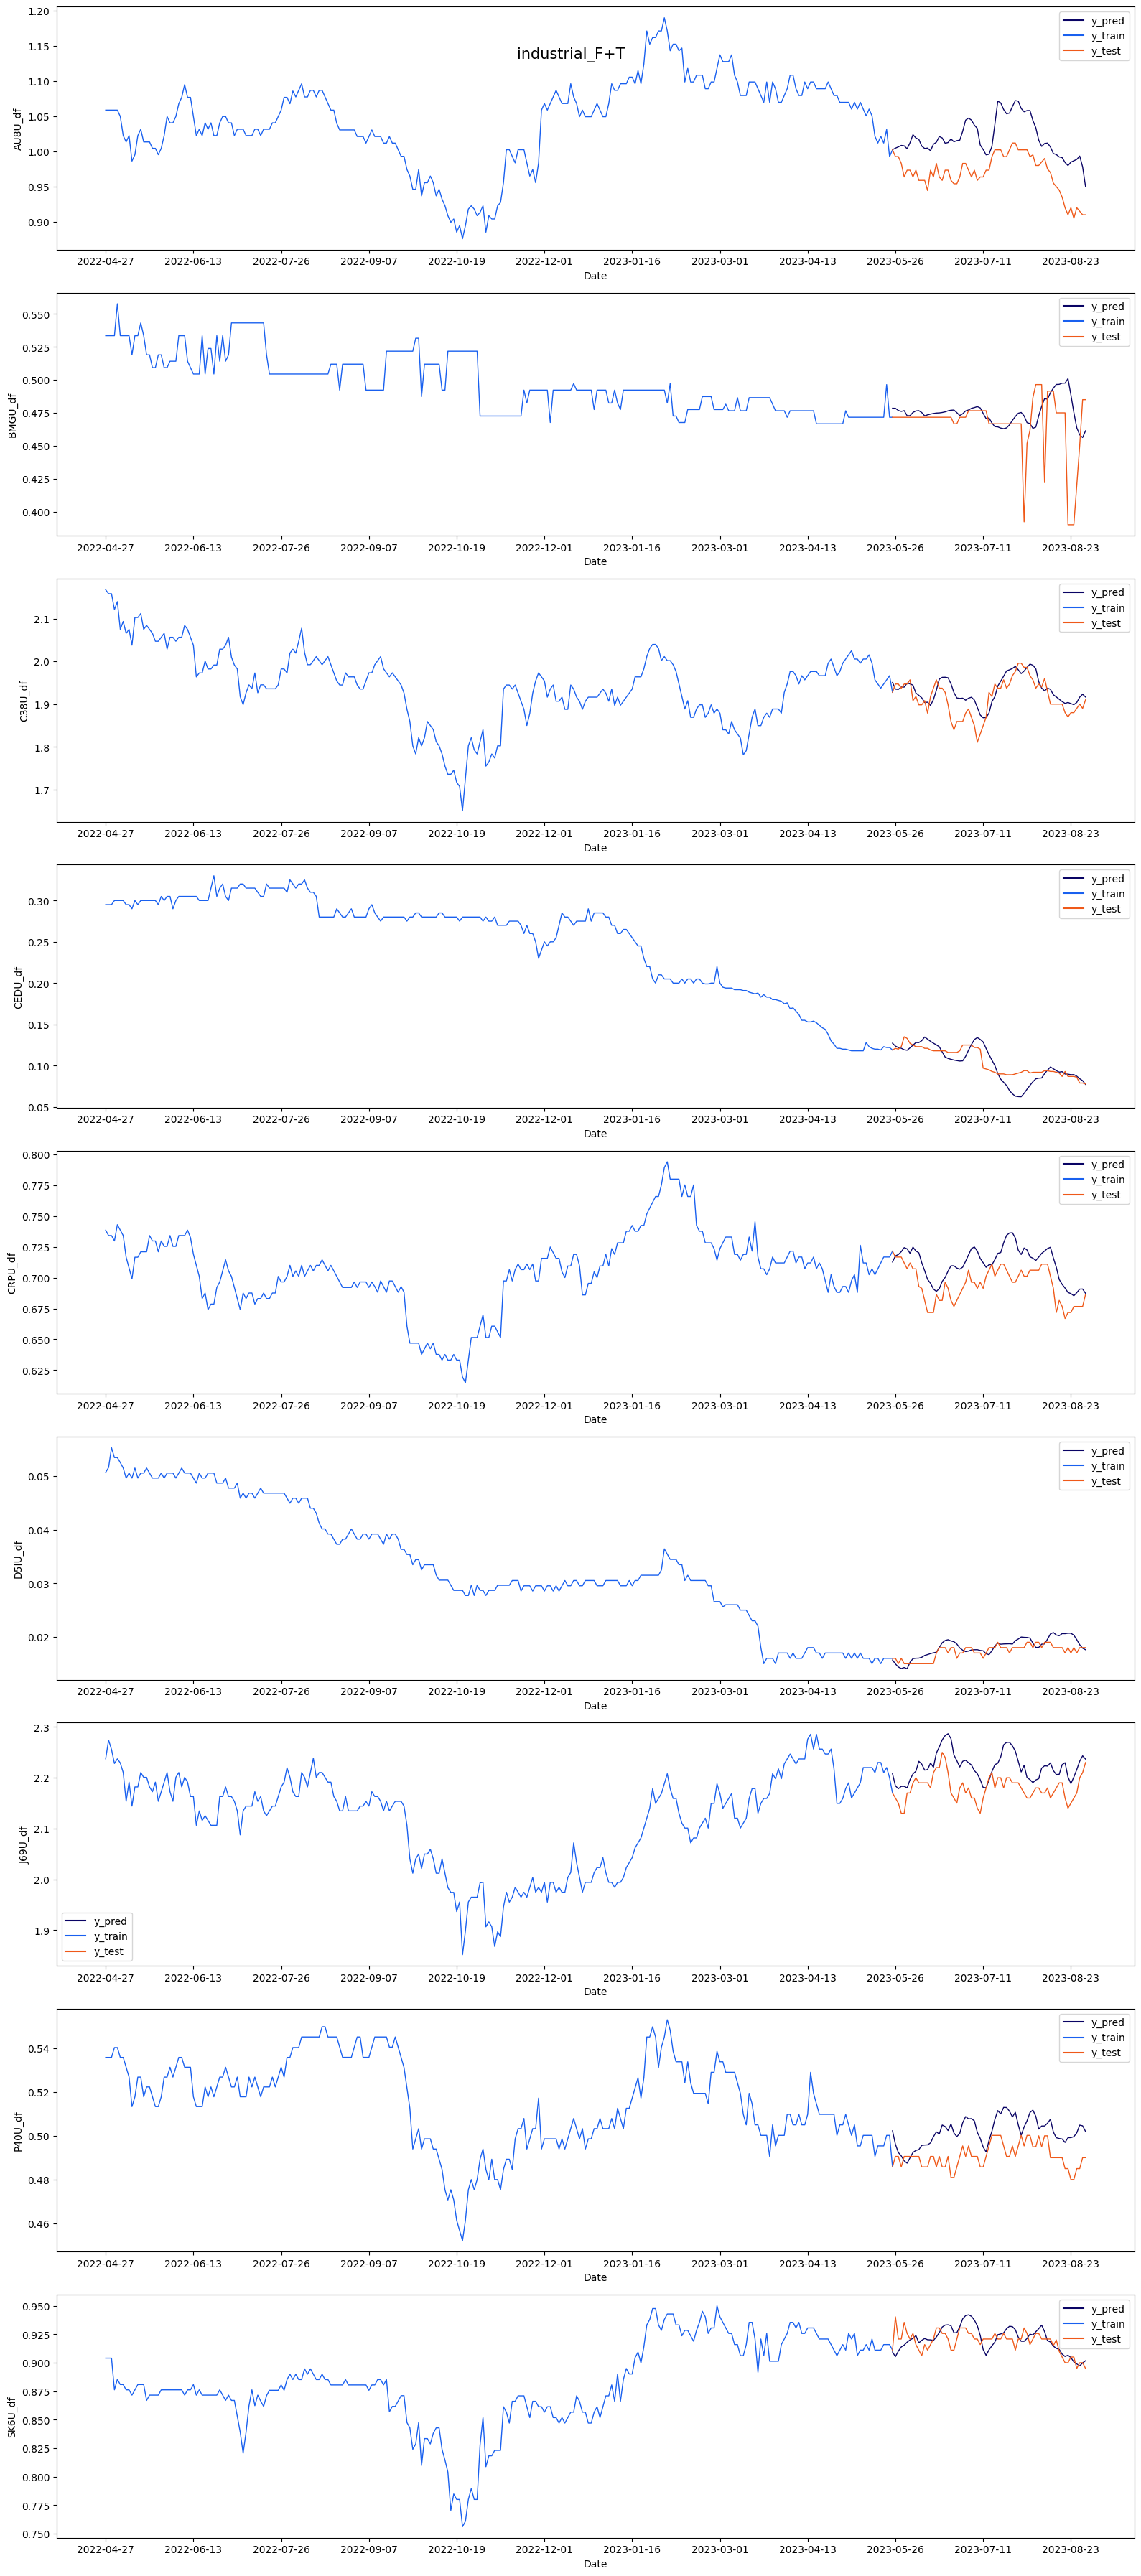

In [ ]:
#@title Create the lineplot

fig, axes = plt.subplots(len(reits), 1, figsize=(16, len(reits)*4))
sector = 'industrial'

i = 0
for dataset_name, df_union_zoom in datasets_zoom.items():
  axes[i].set_xticks(np.arange(0, nrows, 30))
  axes[i].set_ylabel(dataset_name, fontsize = 10)
  sns.set_palette(["#090364", "#1960EF", "#EF5919"])
  sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=axes[i])
  i += 1
  # Create the bar plot with the differences
  #df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
  #axes[0].bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
  plt.legend()

plt.tight_layout()
plt.suptitle(f"{sector}_F+T", fontsize = 15)
plt.savefig(f'{sector}_7ts_{token_model}.png')  # Save the plot as a PNG file
plt.show()

In [ ]:
#@title show Metrics

metric_dict = {}
for d in [MAE_dict, MAPE_dict, MDAPE_dict, RMSE_dict, R2_dict]:
    for key, value in d.items():
        if key in metric_dict:
            metric_dict[key].append(value)
        else:
            metric_dict[key] = [value]

metric_df = pd.DataFrame(metric_dict)
metric_df.index = ['MAE', 'MAPE', 'MDAPE', 'RMSE', 'R2']
metric_df.to_csv(f"{sector}_metrics_{token_model}.csv")